In [1]:
### imports

import keras
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
import awkward as ak
from tqdm.notebook import tqdm

In [2]:
# latex settings block

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.numpoints": 1,
    "axes.linewidth": 2,
    "legend.title_fontsize": 18,
    "axes.labelsize": 18,
    "legend.fontsize": 16
})

In [3]:
# load feature and label arrays from an npz file for training
with np.load("root_files/combined_train.npz") as file:
    feature_array = file['features']
    label_array = file['labels']
    features = file['names'].tolist()
    
nfeatures = len(features)
nlabels = 2

In [4]:
# separate train signal and background events in dataframes
df = pd.DataFrame(feature_array, columns=features)
bkg = df[label_array[:,0]==1]
sig = df[label_array[:,1]==1]

In [5]:
# all dels in this notebook are to clear up RAM
del feature_array, label_array

In [6]:
# load feature and label arrays from an npz file for testing/validation
with np.load("root_files/combined_test.npz") as file:
    feature_array_test = file['features']
    label_array_test = file['labels']

In [7]:
# separate test signal and background events in dataframes
df_test = pd.DataFrame(feature_array_test, columns=features)
bkg_test = df_test[label_array_test[:,0]==1]
sig_test = df_test[label_array_test[:,1]==1]

In [8]:
del feature_array_test, label_array_test

In [9]:
# just a renaming in case someone wants to do out some outlier removal
# the "_out" dataframes are supposed to have their outliers removed 
sig_train_out = sig
bkg_train_out = bkg
sig_test_out = sig_test
bkg_test_out = bkg_test

In [10]:
# view the shapes of the dataframes
print(bkg.shape)
print(bkg_train_out.shape)
print(bkg_test.shape)
print(bkg_test_out.shape)

(11734326, 49)
(11734326, 49)
(1467277, 49)
(1467277, 49)


In [11]:
del bkg, sig, bkg_test, sig_test, df

In [12]:
# sample background events equal to the amount of our available signal events for training and validation purposes
# the backgrounds events are generally a lot more but we want to keep the sets 50-50
bkg_train_out = bkg_train_out.sample(len(sig_train_out)).reset_index(drop=True)
bkg_test_out = bkg_test_out.sample(len(sig_test_out)).reset_index(drop=True)

In [13]:
# check the the final shapes are indeed equal
print(bkg_train_out.shape)
print(sig_train_out.shape)
print(bkg_test_out.shape)
print(sig_test_out.shape)

(1782913, 49)
(1782913, 49)
(222732, 49)
(222732, 49)


  0%|          | 0/48 [00:00<?, ?it/s]

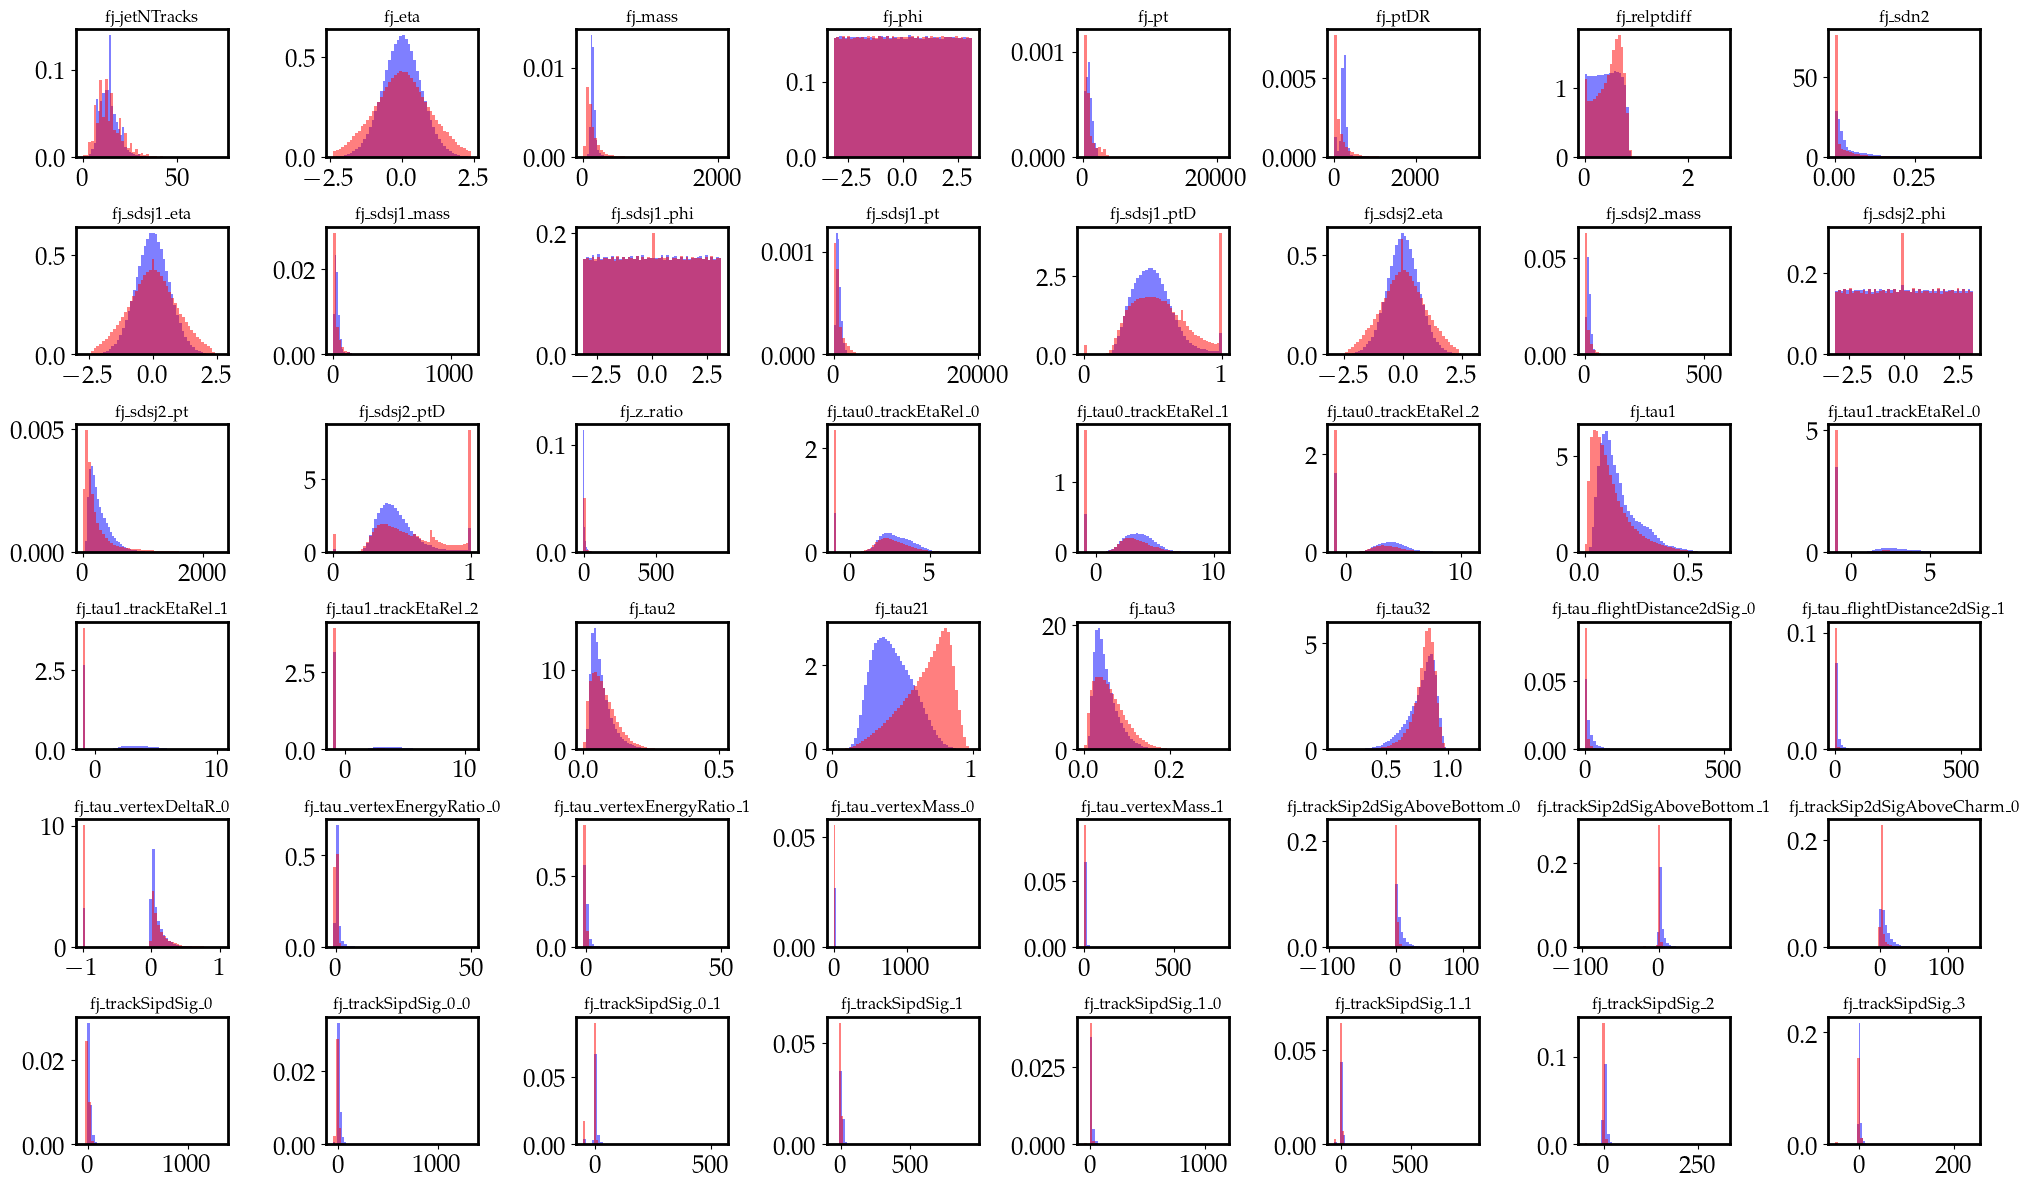

In [14]:
# plot 48/49 variable histograms into a grid
# blue histograms are signal events and red are background events
fig, axes = plt.subplots(6,8, figsize=(20,12))

features_to_plot = sig_train_out.columns.drop('fj_nSV')

for ax, label in tqdm(zip(axes.ravel(), features_to_plot), total = len(features_to_plot)):
    ax.hist(sig_train_out[label],density=True,color='b',alpha=0.5,bins=50)
    ax.hist(bkg_train_out[label],density=True,color='r',alpha=0.5,bins=50)
    ax.set_title(label)

plt.tight_layout()
plt.savefig('plots/hists.pdf')
plt.show()

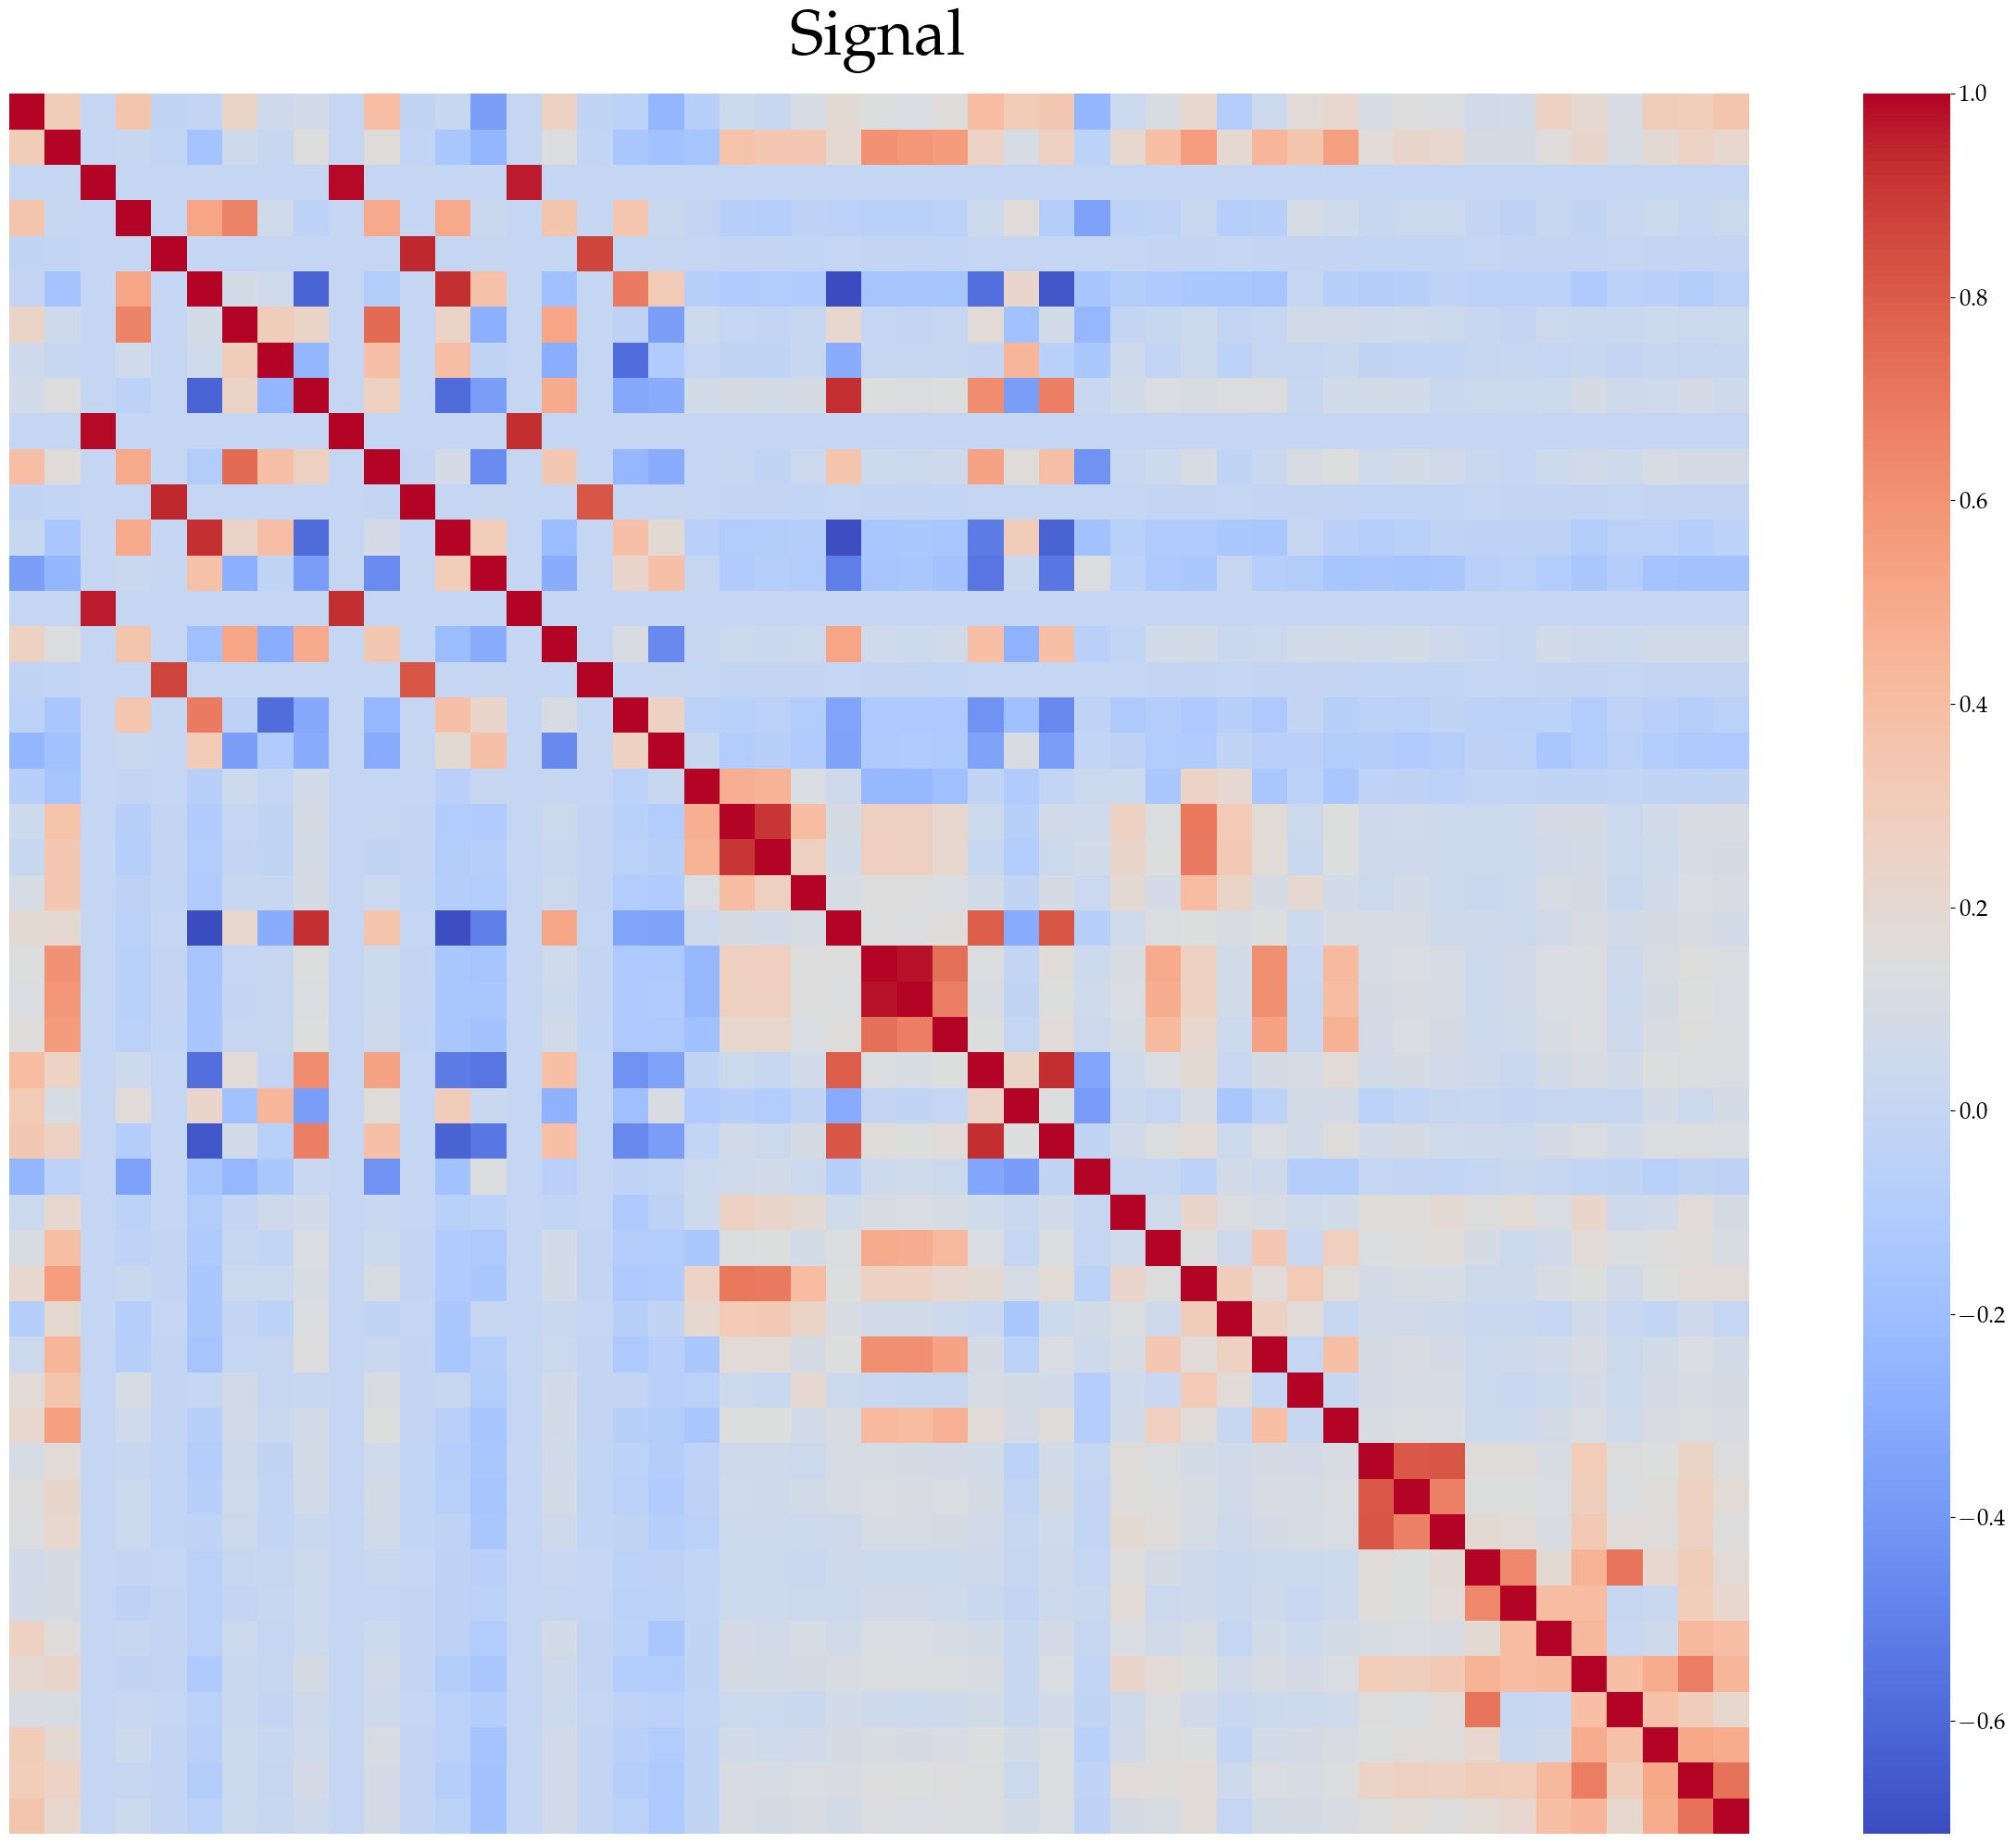

In [15]:
# plot correlation matrix of signal events in the training set
plt.figure(figsize=(25,20))
sns.heatmap(sig_train_out.corr(), cmap='coolwarm',annot=False, fmt='.2f', square=True,
            xticklabels=False, yticklabels=False)
plt.title('Signal', fontsize=50, pad=30)
plt.tight_layout()
plt.savefig('plots/corr_sig.pdf', bbox_inches='tight')
plt.show()

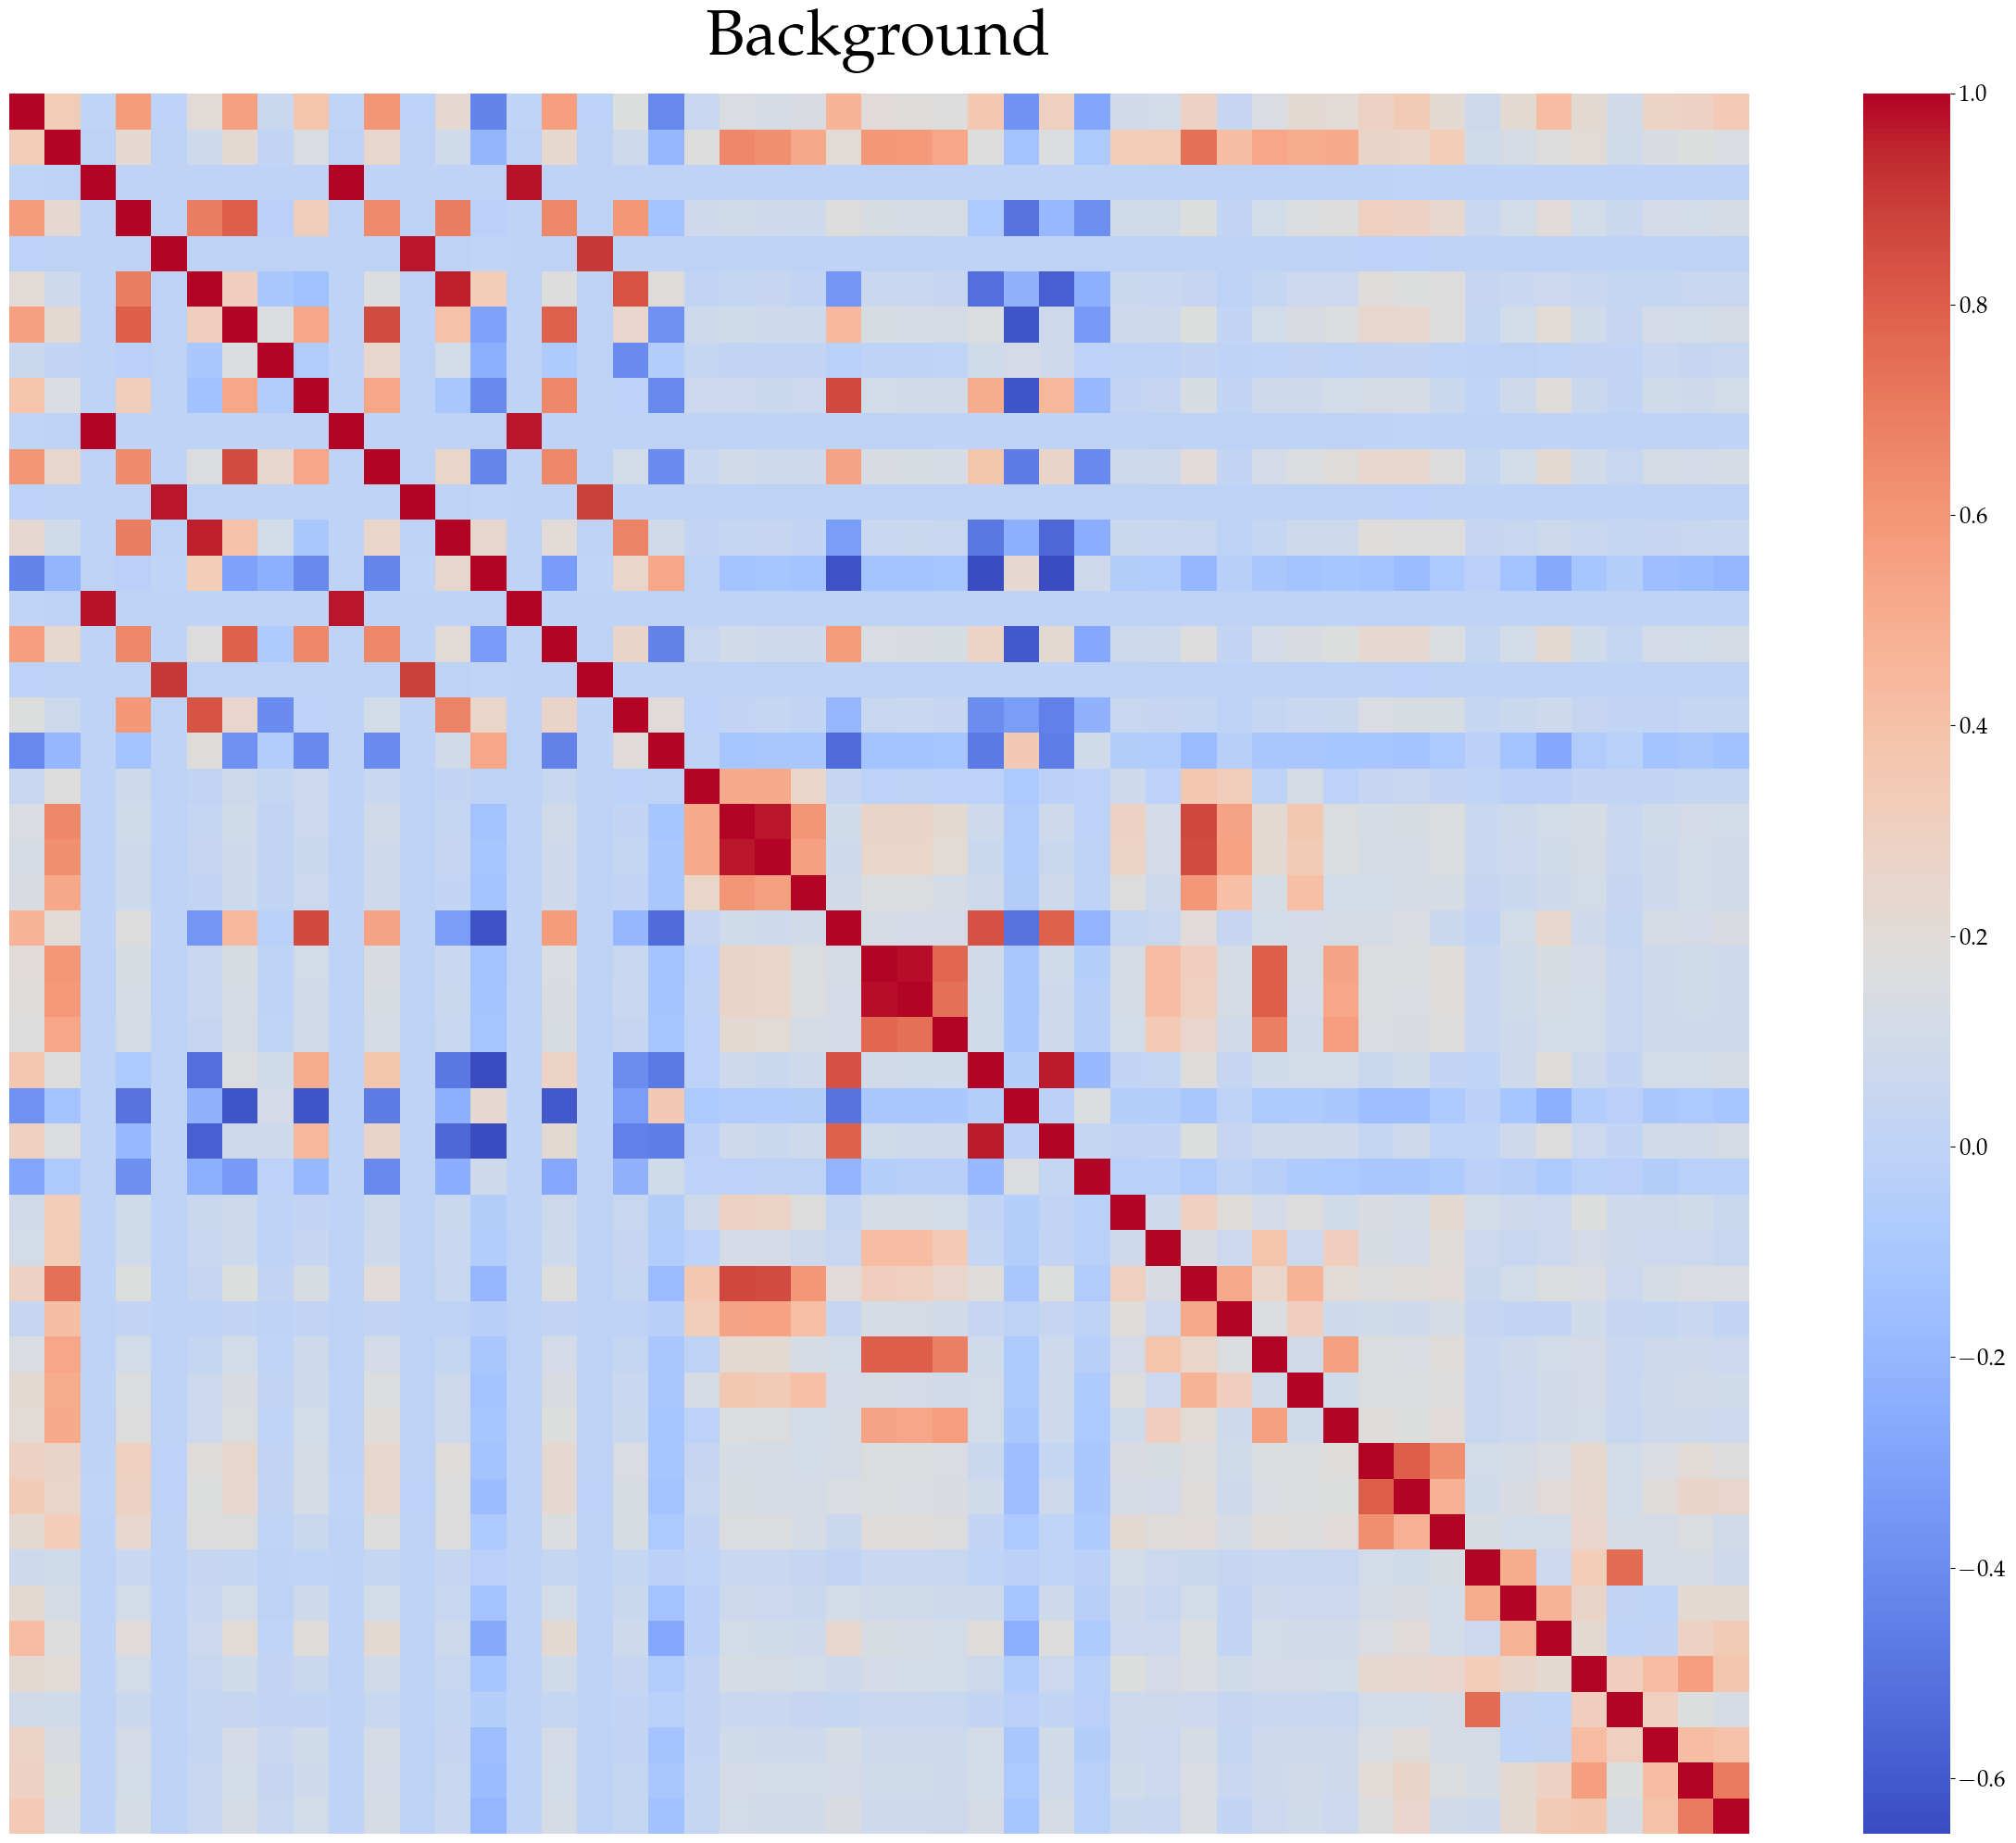

In [16]:
# plot correlation matrix of background events in the training set
plt.figure(figsize=(25,20))
sns.heatmap(bkg_train_out.corr(), cmap='coolwarm',annot=False, fmt='.2f', square=True, 
            xticklabels=False, yticklabels=False)
plt.title('Background', fontsize=50, pad=30)
plt.tight_layout()
plt.savefig('plots/corr_bkg.pdf', bbox_inches='tight')
plt.show()

In [17]:
# combine the training signal and background dataframes into one with appropriate labeling columns
hbb = np.concatenate((np.ones(len(sig_train_out)),np.zeros(len(bkg_train_out))), axis=None)
QCD = np.concatenate((np.zeros(len(sig_train_out)),np.ones(len(bkg_train_out))), axis=None)
traindata = pd.concat([sig_train_out, bkg_train_out])
traindata['hbb'] = hbb
traindata['QCD'] = QCD

# shuffle and extract training feature and label arrays
train = traindata.sample(frac=1).reset_index(drop=True)
X_train = train.iloc[:,:-2]
y_train = train.iloc[:,-2:]

In [18]:
del traindata

In [19]:
# combine the testing signal and background dataframes into one with appropriate labeling columns
hbb = np.concatenate((np.ones(len(sig_test_out)),np.zeros(len(bkg_test_out))), axis=None)
QCD = np.concatenate((np.zeros(len(sig_test_out)),np.ones(len(bkg_test_out))), axis=None)
testdata = pd.concat([sig_test_out, bkg_test_out])
testdata['hbb'] = hbb
testdata['QCD'] = QCD

# shuffle and extract testing feature and label arrays
test = testdata.sample(frac=1).reset_index(drop=True)
X_test = test.iloc[:,:-2]
y_test = test.iloc[:,-2:]

In [20]:
del testdata

In [21]:
%%time
# perform standard scaling on the training and testing arrays
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)

CPU times: user 532 ms, sys: 224 ms, total: 756 ms
Wall time: 755 ms


In [22]:
# get the eigenvalues and eigenvectors of the training set covariance matrix
eigenvalues, eigenvectors = np.linalg.eig(X_train.cov())

In [23]:
# sort the eigenvalues and the eigenvecors according to their eigenvalues
# that's essentially what PCA does
# it is transforming the features according to the sorted eigenvector matrix
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

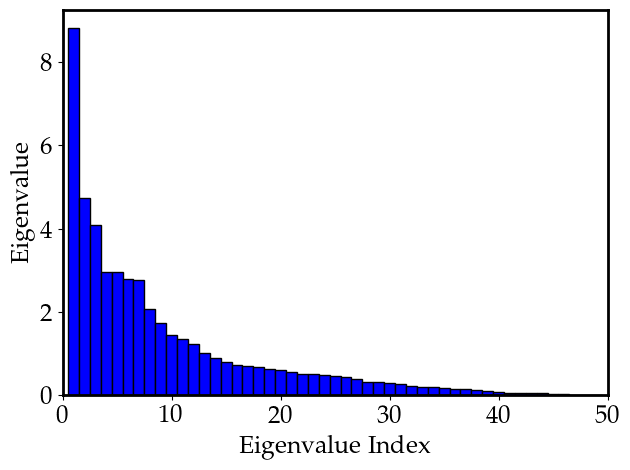

In [24]:
# plot the sorted eigenvalues in decreasing order to see where "big drops"
# we do this to decide how many principal components we want to keep (if we want to use PCA) after performing PCA
plt.figure()
x = np.arange(1,nfeatures+1)
plt.xlim(0,nfeatures+1)
plt.bar(x,eigenvalues,color='b',width=1,edgecolor='k')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.tight_layout()
plt.savefig('plots/eigenvalues.pdf')
plt.show()

In [25]:
%%time
# perform PCA
pca = PCA()
pca.fit(X_train)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))
print(pca.singular_values_)

[1.79869870e-01 9.67852563e-02 8.34179332e-02 6.05424547e-02
 6.01341440e-02 5.70963803e-02 5.62427051e-02 4.20793537e-02
 3.54073115e-02 2.96230041e-02 2.75250174e-02 2.48764349e-02
 2.06963329e-02 1.81814138e-02 1.64487663e-02 1.46231209e-02
 1.42330609e-02 1.35986581e-02 1.27453908e-02 1.23801898e-02
 1.14968866e-02 1.03750159e-02 1.02593921e-02 1.00194154e-02
 9.18919217e-03 8.70462553e-03 7.70757362e-03 6.41246331e-03
 6.28245809e-03 6.11603459e-03 5.43636381e-03 4.21721554e-03
 4.08346344e-03 3.76965773e-03 3.30796959e-03 3.03532022e-03
 2.75571008e-03 2.41830069e-03 2.07701325e-03 1.24663525e-03
 9.93566232e-04 9.07145408e-04 8.78094587e-04 8.21340690e-04
 3.69464394e-04 2.74224743e-04 1.94610587e-04 8.33429316e-05
 6.07051549e-05]
[0.17986987 0.27665513 0.36007306 0.42061551 0.48074966 0.53784604
 0.59408874 0.6361681  0.67157541 0.70119841 0.72872343 0.75359986
 0.7742962  0.79247761 0.80892638 0.8235495  0.83778256 0.85138122
 0.86412661 0.8765068  0.88800368 0.8983787  0.908

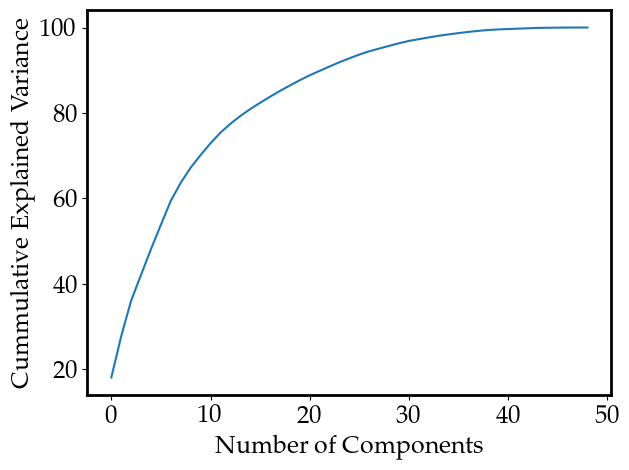

In [26]:
# plot the cummulative explained variance vs number of principal components
# with this plot we can decide how many principal components we want to keep for dimensionality reduction
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel('Number of Components')
plt.ylabel('Cummulative Explained Variance')
plt.tight_layout()
plt.savefig('plots/pca_explained_variance.pdf')
plt.show()

In [28]:
# define function that calculates the divergence between two sets of observations
def KL(feature1 ,feature2 , bins = 100, eps = 1e-8):
    '''
    This function calculates the divergence between two sets of observations.
    INPUTS:
        feature1, feature2: arrays of observations.
        bins: number of bins when histogramming those arrays.
        eps: small quantity to avoid NaNs in logarithms of Kullback–Leibler divergence.
    OUTPUTS:
        divergence between the distributions of the two arrays.
    
    This function first histograms the data in the same range and bins,
    then it calculates the Kullback–Leibler divergence of feature1 with feature2 and then of feature2 with feature1.
    It adds up the two divergences and returns the "unified" divergence as the output.
    '''
    low, high = (np.min([np.min(feature1),np.min(feature2)]), np.max([np.max(feature1),np.max(feature2)]))
    pk, bins = np.histogram(feature1, bins=bins, range=(low,high))
    qk, bins = np.histogram(feature2, bins=bins, range=(low,high))
    pk = pk + eps
    qk = qk + eps
    D1 = stats.entropy(pk, qk)
    D2 = stats.entropy(qk, pk)
    divergence = D1 + D2
    return divergence

In [29]:
# calculate the divergences between of the distributions of signal and background events for all feature variables
# print the divergences of each variable in a sorted manner from largest to smallest
div = []
for i in tqdm(features):
    divergence = KL(sig_train_out[i], bkg_train_out[i])
    div.append(divergence)
divergences = pd.Series(div, index=features).sort_values(ascending=False)
print(divergences)

  0%|          | 0/49 [00:00<?, ?it/s]

fj_mass                          2.591038
fj_ptDR                          2.341443
fj_tau21                         2.233210
fj_trackSip2dSigAboveBottom_0    1.409107
fj_sdsj2_mass                    1.394983
fj_trackSip2dSigAboveCharm_0     1.174370
fj_sdsj1_mass                    1.163823
fj_sdsj2_pt                      1.143414
fj_sdn2                          1.093652
fj_trackSip2dSigAboveBottom_1    1.070014
fj_trackSipdSig_0                1.062917
fj_tau_flightDistance2dSig_0     0.933214
fj_pt                            0.922827
fj_trackSipdSig_0_0              0.844959
fj_tau_vertexEnergyRatio_0       0.760148
fj_nSV                           0.708562
fj_sdsj1_pt                      0.666600
fj_tau_vertexDeltaR_0            0.603005
fj_trackSipdSig_0_1              0.599277
fj_tau_vertexEnergyRatio_1       0.597635
fj_trackSipdSig_1                0.587744
fj_sdsj2_ptD                     0.565082
fj_tau1                          0.561003
fj_trackSipdSig_2                0

  0%|          | 0/6 [00:00<?, ?it/s]

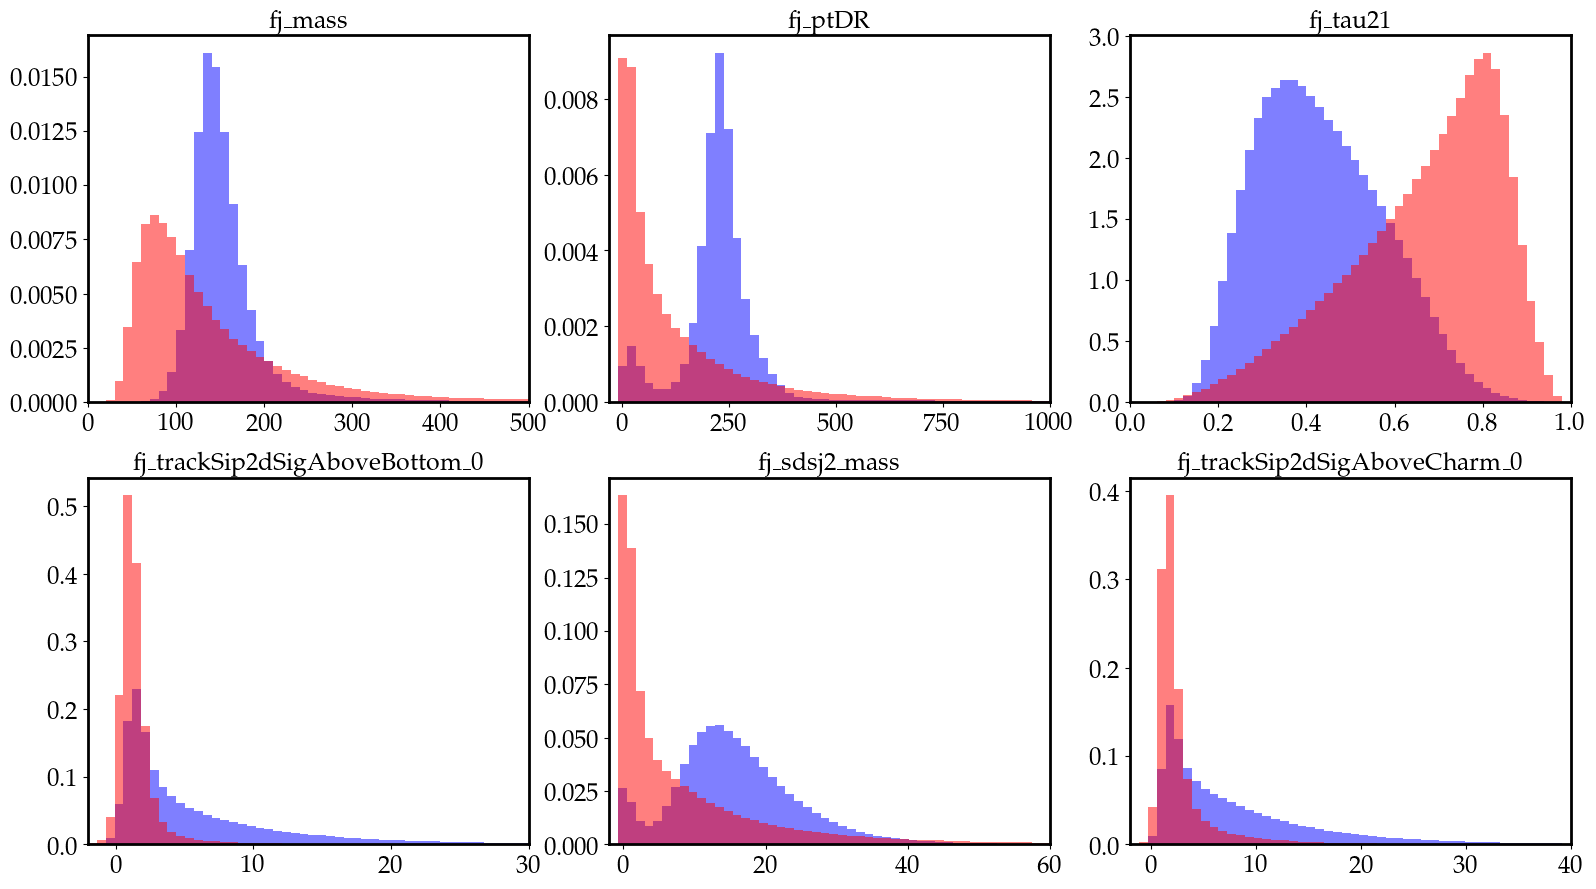

In [30]:
# histogram the 6 variables with the largest divergence
fig, axes = plt.subplots(2,3, figsize=(16,9))

features_to_plot = divergences.index.tolist()[:6]

lims = [(0,500),(-30,1000),(0,1),(-2,30),(-2,60),(-2,40)]

for ax, label, lim in tqdm(zip(axes.ravel(), features_to_plot, lims), total = len(features_to_plot)):
    ax.hist(sig_train_out[label],density=True,color='b',alpha=0.5,bins=50, range=lim)
    ax.hist(bkg_train_out[label],density=True,color='r',alpha=0.5,bins=50, range=lim)
    ax.set_title(label,fontsize=18)
    ax.set_xlim(lim)
    
plt.tight_layout()
plt.savefig('plots/high_divergence_hists.pdf')
plt.show()

In [31]:
# define the final training and testing datasets
# we can choose to use PCA transformed datasets or not
# we can also choose to use a specific number of principal components only
# use only 2 lines of the code accordingly

# X_train_final = pd.DataFrame(pca.transform(X_train)).iloc[:,:20]
# X_test_final =  pd.DataFrame(pca.transform(X_test)).iloc[:,:20]
X_train_final = X_train
X_test_final =  X_test

In [32]:
# save the final feature and label arrays, the names of the used features and the labels into a single npz file
# the name of the file is "train_test_<# of features>variables.npz" and is saved inside the "root_files" folder
np.savez(f'root_files/train_test_{len(features)}variables.npz', 
         X_train = X_train_final, y_train = y_train, X_test = X_test_final, y_test = y_test,
         variables = features, labels = ['Hbb', 'QCD'])